In [1]:
import torch
from dlc_practical_prologue import generate_pair_sets
import torch.nn as nn
from print_util import *
import matplotlib.pyplot as plt

## 1. Generate raw data, process it

In [28]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(1000)

In [29]:
def normalize_data(tensor):
    mu, std = tensor.mean(), tensor.std()
    tmp = tensor.sub(mu).div(std)
    return tmp

In [30]:
def convert_to_one_hot_labels(target):
    tmp = target.new_zeros(target.size(0), target.max() + 1)
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    return tmp

_We normalized the data so it has mean 0 and std 1._

In [31]:
train_input = normalize_data(train_input)


test_input = normalize_data(test_input)

In [32]:
print("Training set mean = {a}".format(a = train_input.mean().item()))
print("Training set std = {s}\n".format(s = train_input.std().item()))
print("Test set mean = {a}".format(a = test_input.mean().item()))
print("Test set std = {s}".format(s = test_input.std().item()))

Training set mean = 3.042999452418371e-08
Training set std = 1.0

Test set mean = 5.719904834222689e-07
Test set std = 0.9999999403953552


_We will create a validation set to tune hyperparameters. This validation set is created from the training set in order to have fully independent testing data._

_80% of the training data goes to training and the remaining 20% for our validation set._

In [33]:
index_permutation = torch.randperm(train_input.size(0))

validation_proportion = 0.2
split = int(0.2 * train_input.size(0))

validation_index = index_permutation[:split]
training_index = index_permutation[split:]

validation_input = train_input[validation_index]
validation_target = train_target[validation_index]
validation_classes = train_classes[validation_index]

train_input = train_input[training_index]
train_target = train_target[training_index]
train_classes = train_classes[training_index]

In [34]:
print(train_input.size(0))
print(validation_input.size(0))

800
200


## 2. Creating & Training models

In [35]:
import models
import torch.nn.functional as F

In [50]:
BATCH_SIZE = 64

In [51]:
basic_model = models.BaselineNetwork()

In [52]:
def test(test_input, test_target, test_classes, model, criterion, batch_size):
    
    with torch.no_grad():
        nb_data_errors = 0
        loss_sum = 0
        
        for inputs, targets in zip(test_input.split(batch_size),
                                  test_target.split(batch_size)):
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss_sum += loss
            _, predicted_classes = torch.max(outputs, 1)
            
            for k in range(len(inputs)):
                if targets[k] != predicted_classes[k]:
                    nb_data_errors = nb_data_errors + 1

        accuracy = (1 - (nb_data_errors / test_input.size(0))) * 100
        
        return accuracy, loss_sum.item()

In [53]:
def train_model(model, train_input, train_target, train_classes, test_input, test_target, test_classes, nb_epoch, batch_size, optimizer_params, logging = False):
    
    nb_epoch, batch_size = nb_epoch, batch_size
    lr, momentum = optimizer_params['lr'], optimizer_params['momentum']
    
    optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = momentum)
    criterion = nn.CrossEntropyLoss()
    
    if logging:
        log_acc_loss_header(color=Color.GREEN)
    
        train_accuracies = []
        train_losses = []
        test_accuracies = []
        test_losses = []
    
    for e in range(nb_epoch):
        for inputs, targets in zip(train_input.split(batch_size),
                                  train_target.split(batch_size)):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if logging:    
            train_acc, train_loss = test(train_input, train_target, train_classes, model, criterion, batch_size)
            test_acc, test_loss = test(test_input, test_target, test_classes, model, criterion, batch_size)
        
            train_accuracies.append(train_acc)
            train_losses.append(train_loss)
            test_accuracies.append(test_acc)
            test_losses.append(test_loss)
        
            log_acc_loss(e, nb_epoch, 0, train_loss, train_acc, test_loss, test_acc, persistent=False)
            
    if logging:
        print()
        return train_accuracies, train_losses, test_accuracies, test_losses

_Testing if the training is done correctly._

In [54]:
train_accuracies, train_losses, test_accuracies, test_losses = train_model(basic_model,
                                                                           train_input, 
                                                                           train_target, 
                                                                           train_classes, 
                                                                           test_input, 
                                                                           test_target, 
                                                                           test_classes, 
                                                                           100, 
                                                                           BATCH_SIZE, 
                                                                           {'lr': 0.01, 'momentum':0.9}, 
                                                                           logging = True)

Epoch       Time    Train loss     Train accuracy      Test loss      Test accuracy       
[100/100]   0s      0.0064         100.0000            19.2309        79.9000             


_We will now tune hyperparameters. For now, we are tuning the learning rate, the momemtum and the number of epochs._

In [16]:
learning_rates = [0.001, 0.01] #, 0.1]
momentums = [0.9] #[0.5, 0.7, 0.9]
nb_epochs = [20, 50, 100] #, 100]

best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for momentum in momentums:
        for nb_epoch in nb_epochs:
            
                # creating params for optimizer
                optimizer_params = {'lr':lr, 'momentum':momentum}
                
                # initialize raw model
                model = models.BaselineNetwork()
                
                # train model on training data
                train_model(model,
                            train_input,
                            train_target,
                            train_classes,
                            None,
                            None,
                            None,
                            nb_epoch, BATCH_SIZE, optimizer_params)
                
                # compute accuracy on validation data
                accuracy, loss = test(validation_input, validation_target, validation_classes, model, nn.CrossEntropyLoss(), BATCH_SIZE)
                            
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params['lr'] = lr
                    best_params['momentum'] = momentum
                    best_params['nb_epoch'] = nb_epoch
                    
print("Best accuracy obtained = {a}\n".format(a = best_accuracy))
print("with the following hyperparameters:\n")
print(best_params)

Best accuracy obtained = 79.0

with the following hyperparameters:

{'lr': 0.001, 'momentum': 0.9, 'nb_epoch': 100}


## NOTE: Hyperparameters tuning is not optimal yet, do not consider the above results as  good yet.

In [17]:
best_optimizer_params = {'lr': 0.01, 'momentum': 0.9}
best_nb_epoch = 50

_Now that we have the best hyperparameters let's retrained the model and visualize the evolution of accuracy and loss on both the train and test sets._

In [18]:
def plot_acc_loss(train_accuracies, train_losses, test_accuracies, test_losses):
    n = len(train_accuracies)
    major_ticks = list(range(0, n, 10))
    minor_ticks = list(range(0, n, 1))
    
    fig, axs = plt.subplots(2, dpi=240, figsize=(15, 12))
    axs[0].plot(train_accuracies, color='Blue')
    axs[0].plot(test_accuracies, color='Red')
    axs[0].set_title("Accuracy")
    axs[0].set(xlabel='Training epochs', ylabel='Accuracy (%)')
    axs[0].grid()
    axs[0].legend(['Train set', 'Test set'])
    axs[0].set_xlim(left=0)
    axs[0].set_xlim(right=n-1)
    axs[0].set_xticks(major_ticks)
    axs[0].set_xticks(minor_ticks, minor=True)
    axs[0].grid(which='minor', alpha=0.3)
    axs[0].grid(which='major', alpha=0.7)
    
    axs[1].plot(train_losses, color='Blue')
    axs[1].plot(test_losses, color='Red')
    axs[1].set_title("Cross-Entropy Loss")
    axs[1].set(xlabel='Training epochs', ylabel='Loss')
    axs[1].grid()
    axs[1].legend(['Train set', 'Test set'])
    axs[1].set_xticks(major_ticks)
    axs[1].set_xticks(minor_ticks, minor=True)
    axs[1].grid(which='minor', alpha=0.3)
    axs[1].grid(which='major', alpha=0.7)
    axs[1].set_xlim(left=0)
    axs[1].set_xlim(right=n-1)
    plt.show()

In [21]:
final_model = models.BaselineNetwork()

# We regenerate data to train the model on all the training data available. 
# We don't need the validation split at this step.
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(1000)
train_input = normalize_data(train_input)
test_input = normalize_data(test_input)

In [22]:
train_accuracies, train_losses, test_accuracies, test_losses = train_model(final_model,
                                                                           train_input, 
                                                                           train_target, 
                                                                           train_classes, 
                                                                           test_input, 
                                                                           test_target, 
                                                                           test_classes, 
                                                                           best_nb_epoch, 
                                                                           BATCH_SIZE, 
                                                                           best_optimizer_params, 
                                                                           logging = True)

Epoch       Time    Train loss     Train accuracy      Test loss      Test accuracy       
[50/50]     0s      0.0177         100.0000            16.8302        78.8000             


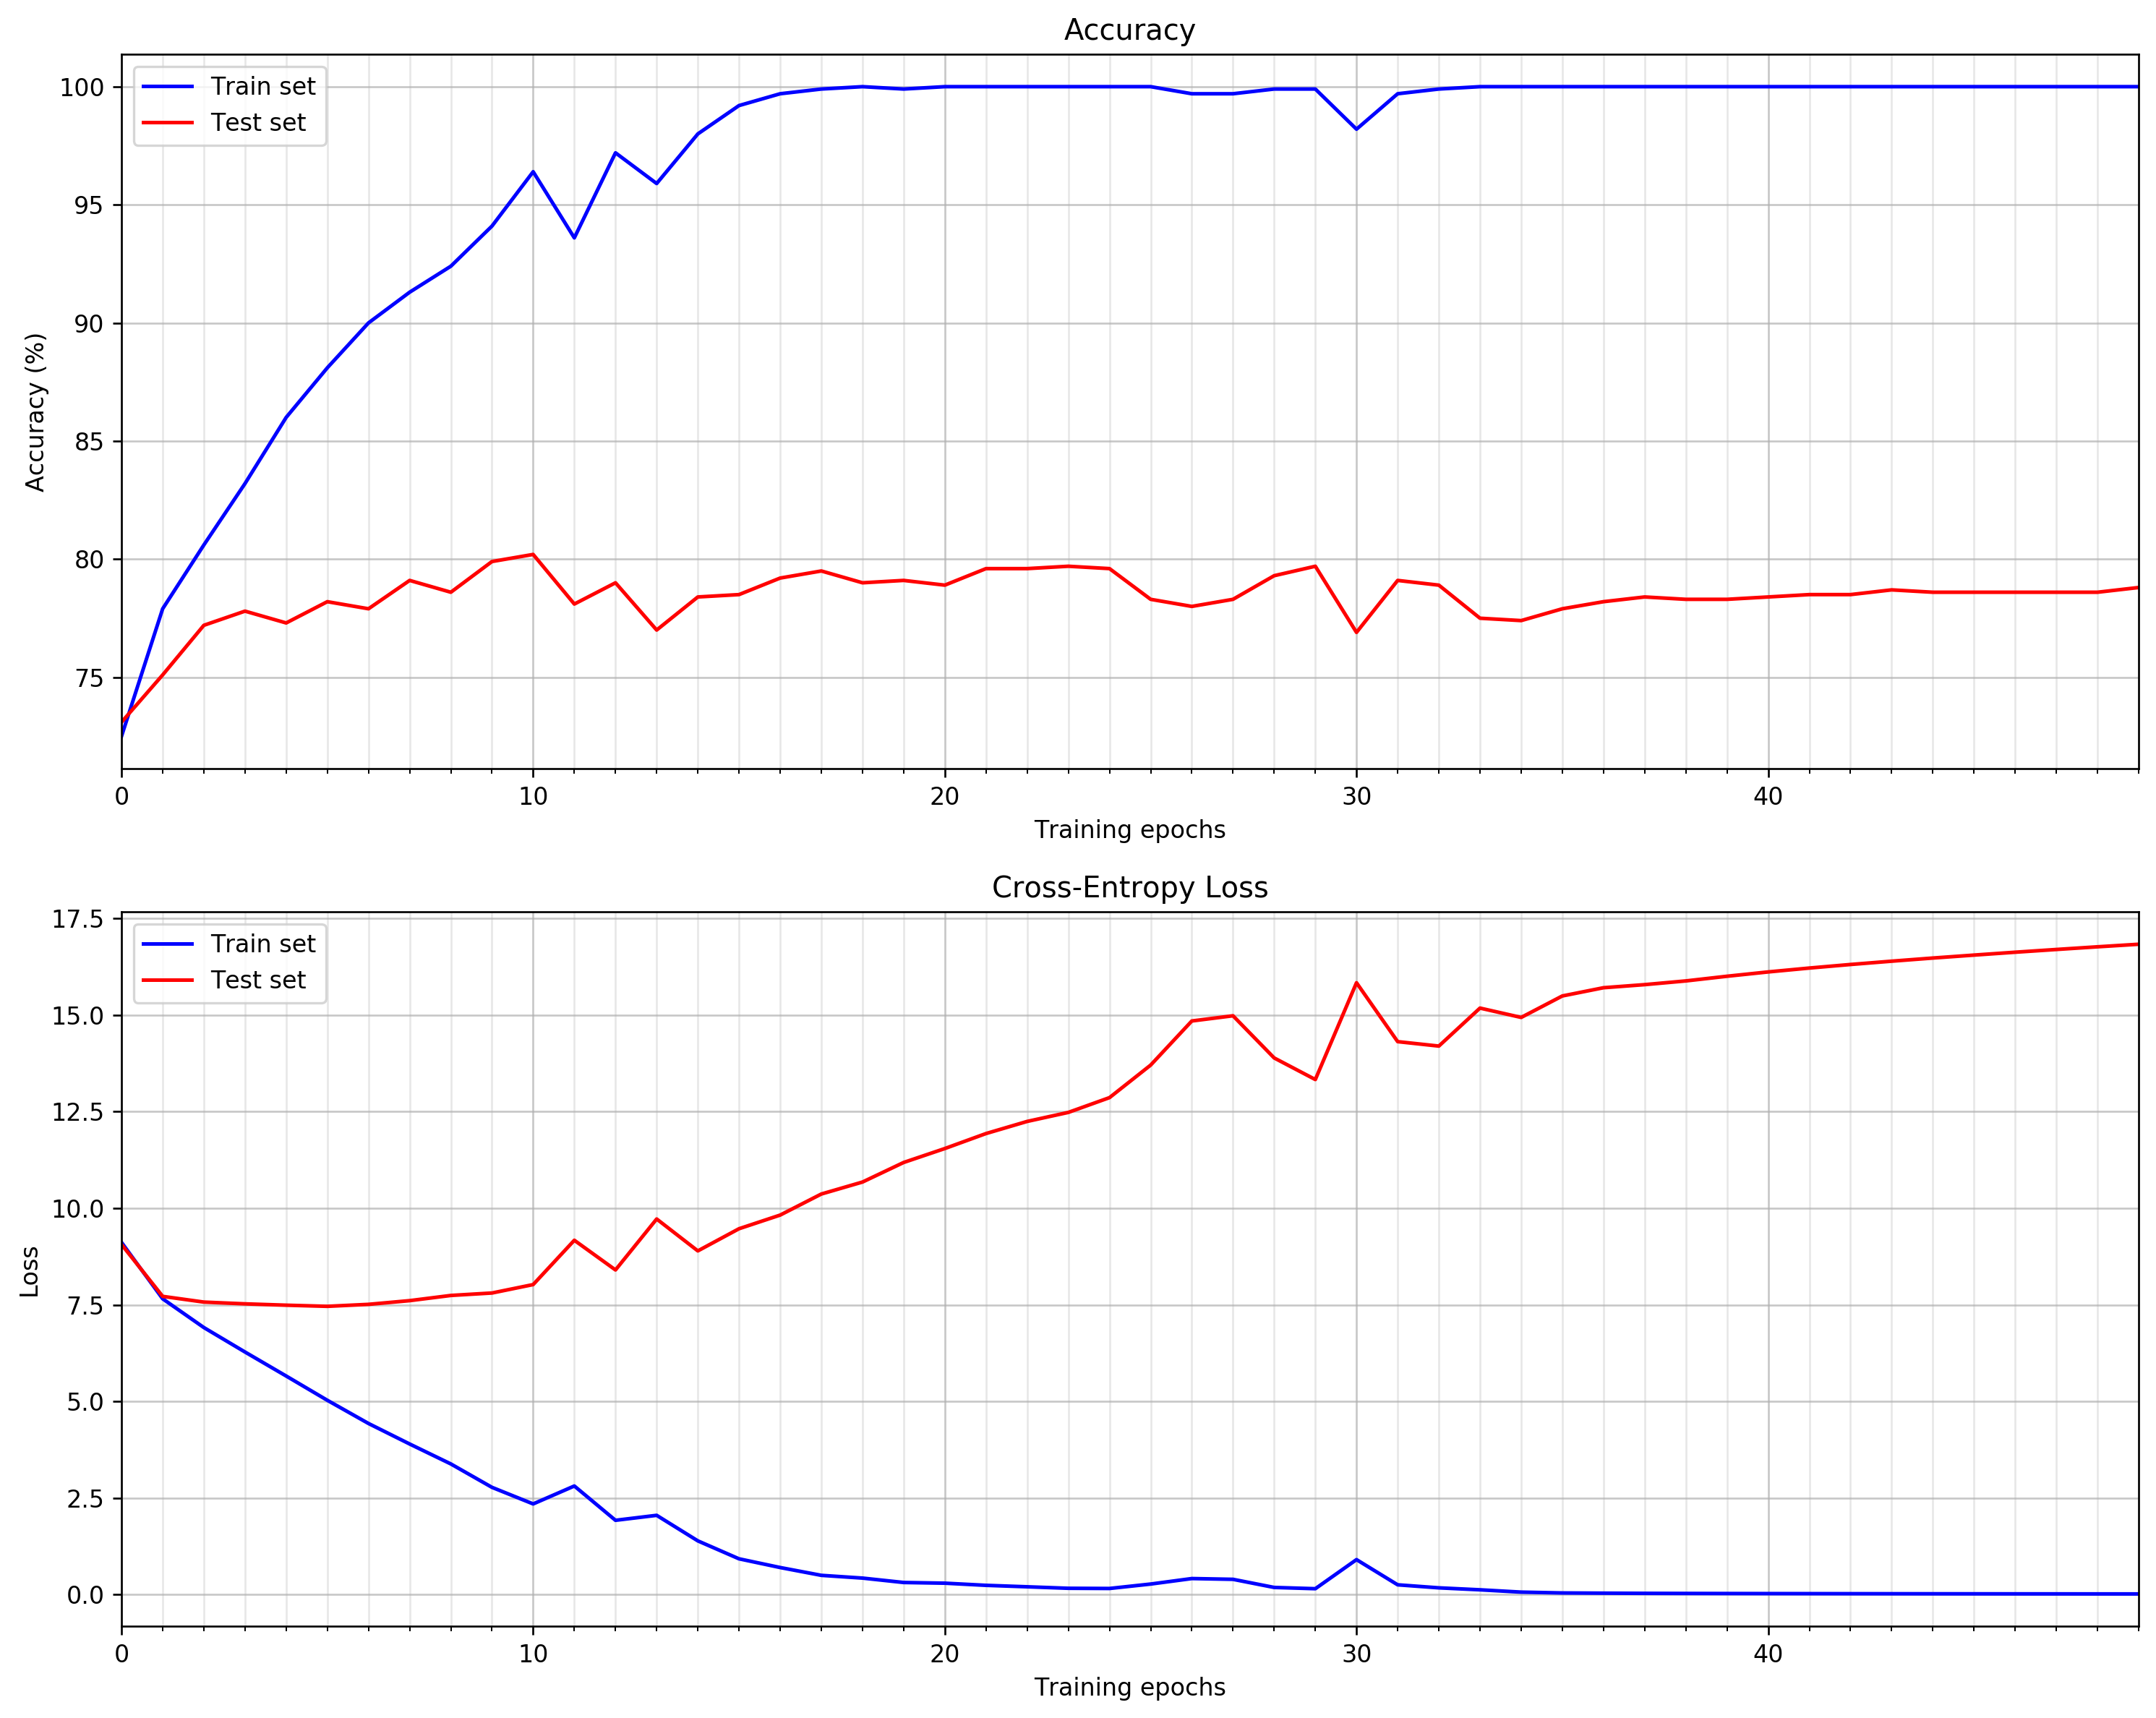

In [23]:
plot_acc_loss(train_accuracies, train_losses, test_accuracies, test_losses)

## 3. Testing model

_In order to test the model we will generate new data (training and test set), retrained the model on the new data en evaluate it on the new test set. We will do this process more than 10 times and estimates the mean accuracy as well as its standard deviation._

In [24]:
nb_rounds = 10
test_model = models.BaselineNetwork

In [25]:
def evaluate_model(model, nb_rounds, criterion):
    
    accuracies = []
    
    for round in range(nb_rounds):
        
        # initialize new model
        model_evaluated = model()
        # generate new data
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(1000)
        train_input = normalize_data(train_input)
        test_input = normalize_data(test_input)
        
        train_model(model_evaluated,
                    train_input,
                    train_target,
                    train_classes,
                    None,
                    None,
                    None,
                    best_nb_epoch, BATCH_SIZE, best_optimizer_params)
        
        accuracy, loss = test(test_input, test_target, test_classes, model_evaluated, criterion, BATCH_SIZE)
        
        print("Round {i}: accuracy = {a}% | loss = {l}".format(i = (round + 1), a = accuracy, l = loss))
        
        accuracies.append(accuracy)
        
    return torch.FloatTensor(accuracies)

In [26]:
accuracies = evaluate_model(test_model, nb_rounds, nn.CrossEntropyLoss())

Round 1: accuracy = 83.2% | loss = 11.378547668457031
Round 2: accuracy = 79.0% | loss = 16.801864624023438
Round 3: accuracy = 76.9% | loss = 16.731538772583008
Round 4: accuracy = 80.2% | loss = 14.957798957824707
Round 5: accuracy = 78.3% | loss = 17.811765670776367
Round 6: accuracy = 79.10000000000001% | loss = 15.783720970153809
Round 7: accuracy = 79.69999999999999% | loss = 14.024261474609375
Round 8: accuracy = 82.3% | loss = 12.495035171508789
Round 9: accuracy = 81.4% | loss = 12.939393997192383
Round 10: accuracy = 79.3% | loss = 17.096384048461914


In [27]:
print("The mean accuracy is: {a}".format(a = accuracies.mean()))
print("The accuracy std is: {s}".format(s = accuracies.std()))

The mean accuracy is: 79.93999481201172
The accuracy std is: 1.8968974351882935
